# Deep Fake Detection
First, let's take a look at the dataset. We have a total of 56000 images, with ~50000 for training and ~6000 for validation as pre-splitted dataset.
We have information on whether the images are fake or real and information on deep fake manipulation like fake identity, fake expression, and fake head pose. However, some other image transformations are not labeled, including color shifts, distortion effects, and artifacts like the image below. Some information from the original image is lost due to the image transformation. It may be difficult to just analyze the image to perform real/fake classification by RGB value due to the loss of information.

*To run this notebook, we need a powerful device. So please make sure your GPU works on PyTorch.* 

In the first step, we perform preprocessing on the dataset.

# 1. Data Preprocessing

We first look into the dataset's distribution:

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
def extract_images_path(root_dir):
    img_path = []
    for root, dirs, files in os.walk(root_dir, topdown=False):
        for name in files:
            if name.endswith('.jpg'):
                filename = os.path.join(root, name)
                img_path.append(filename)
    return img_path

def save_img(images_path, new_dir):
    start_index = len(os.listdir(new_dir))
    for i, img_path in enumerate(images_path):
        img = Image.open(img_path)
        img.save(os.path.join(new_dir, str(start_index+int(i)) + '.jpg'))



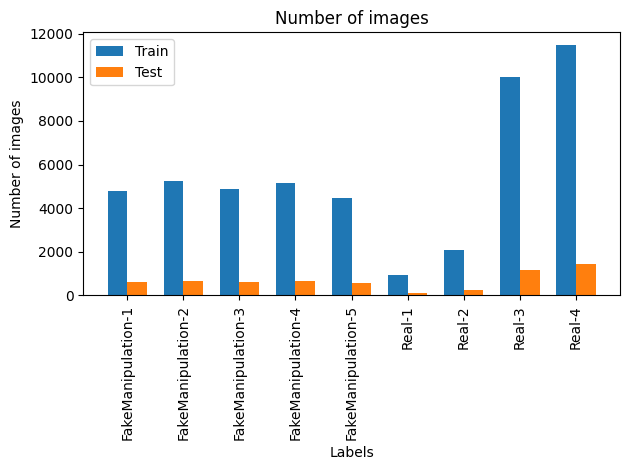

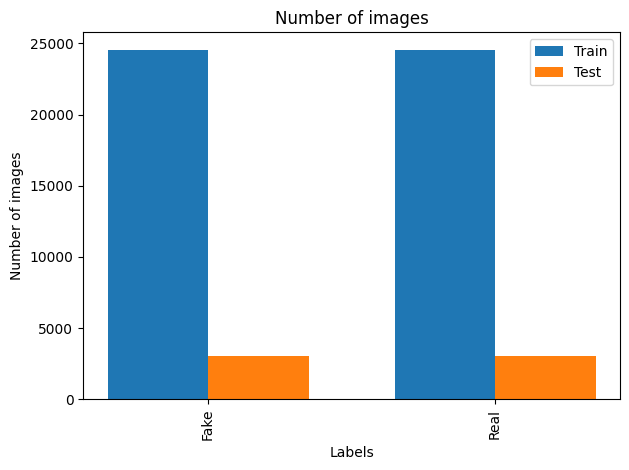

Total number of images: 55136
Total number of fake images: 27616
Total number of real images: 27520


In [2]:
LABELS = [
    "FakeManipulation-1",
    "FakeManipulation-2",
    "FakeManipulation-3",
    "FakeManipulation-4",
    "FakeManipulation-5",
    "Real-1",
    "Real-2",
    "Real-3",
    "Real-4"
]
ORIGINAL_DATASET_PATH = "./project_data"
train_img_count = {}
test_img_count = {}
# Train images
for label in LABELS:
    train_img_count[label] = len(extract_images_path(os.path.join(ORIGINAL_DATASET_PATH, "train",label)))
    test_img_count[label] = len(extract_images_path(os.path.join(ORIGINAL_DATASET_PATH, "val",label)))
    
# plot the distribution
# bar chat, x is the label, y is the number of images, concatenate train and test as two bars on the same label and seperate them by color
labels = list(train_img_count.keys())
train_count = list(train_img_count.values())
test_count = list(test_img_count.values())


def bar_plot(labels, a_count, b_count):
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars
    fig, ax = plt.subplots(layout='tight')
    bar_a = ax.bar(x - width/2, a_count, width, label='Train')
    bar_b= ax.bar(x + width/2, b_count, width, label='Test')
    
    ax.set_ylabel('Number of images')
    ax.set_xlabel('Labels')
    ax.set_title('Number of images')
    # xtick labels 90 degree
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=90)
    ax.legend()
    
    fig.tight_layout()
    plt.show()

bar_plot(labels, train_count, test_count)
# number of fake images and real images
fake_train_sum = sum(value for key, value in train_img_count.items() if key.startswith("Fake"))
real_train_sum = sum(value for key, value in train_img_count.items() if key.startswith("Real"))

fake_test_sum = sum(value for key, value in test_img_count.items() if key.startswith("Fake"))
real_test_sum = sum(value for key, value in test_img_count.items() if key.startswith("Real"))

#plot 
bar_plot(["Fake", "Real"], [fake_train_sum, real_train_sum], [fake_test_sum, real_test_sum])

print(f"Total number of images: {sum(train_img_count.values()) + sum(test_img_count.values())}")
print(f"Total number of fake images: {fake_train_sum + fake_test_sum}")
print(f"Total number of real images: {real_train_sum + real_test_sum}")

It can be a multi-label classification problem, that each label are assigned the binary value combination like [1 0 0 0 1]. However, from the plots above, we can see that the original dataset is imbalanced in the real images. Although the fake images are balanced on different label, there are overlapping face manipulation(mani 1 and mani 2 -> identity, mani 3 and 4 -> expression and identity, and mani 5 are expression and head pose.) So the number of fake identity images is dominating others if a multi-class classification is performed directly. We then choose to mix up the images and reduce the problem into a binary classifiation between fake and real.

The code below will mix up the images and save them into a new directory, we also mix up the train and validation splitting since we will do the splitting ourselves to increase the validation size(the original is about 10%). It also prunes all unnecessary intermidiate directory under each label.

In [ ]:
NEW_DATASET_PATH = ".\project_data_2classes\\"
for label in labels:
    train_dir = os.path.join(ORIGINAL_DATASET_PATH, 'train', label)
    test_dir = os.path.join(ORIGINAL_DATASET_PATH, 'val', label)
    print(train_dir)
    print(test_dir)
    images_path = []
    images_path.extend(extract_images_path(train_dir))
    train_img_count = len(images_path)
    images_path.extend(extract_images_path(test_dir))
    test_img_count = len(images_path) - train_img_count
    print(f"Number of images in {label} train: {train_img_count}, test: {test_img_count}, total: {len(images_path)}")

    binary_label = "Fake" if label.startswith("Fake") else "Real"
    save_img(images_path, os.path.join(NEW_DATASET_PATH, binary_label))
    print(f"Finished {label}")

The new dataset directory's size is reduced from ~1GB to ~0.5GB. This process also makes our dataloading part way easier as we dont need to deal with the intermediate directories.

In [19]:
print(os.listdir(NEW_DATASET_PATH))
# assert the number of images are the same
print(f"New Directory: {len(extract_images_path(NEW_DATASET_PATH))} Original Directory: {len(extract_images_path(ORIGINAL_DATASET_PATH))}")

['Fake', 'Real']
New Directory: 55136 Original Directory: 55136


Before training the model, we need to do image augmentation as a part of data preprocessing step. We use the Keras libray to load and perform image augmentation on the dataset. 
The image augmentation includes rotation, width and height shift, horizontal flip, zoom, and shear. The image augmentation is performed on the training dataset only.

Another approaches for image preprocessing is face extraction. We use another library face_recognition to extract the face from the image, which can center the face and resize the images.

```py

# Credit to https://github.com/mantasu/face-crop-plus for the library face_crop_plus
from face_crop_plus import Cropper
from torch.cuda import is_available

INPUT_DIR_FAKE = "project_data_2classes/Fake"
OUTPUT_DIR_FAKE = "project_data_2classes_face_extracted_no_enhance_300px/Fake"

INPUT_DIR_REAL = "project_data_2classes/Real"
OUTPUT_DIR_REAL = "project_data_2classes_face_extracted_no_enhance_300px/Real"


# Initialize cropper
cropper = Cropper(
    output_size=(300, 300),
    output_format="jpg",
    face_factor=0.65,
    strategy="best",
    device = "cuda:0" if is_available() else "cpu",
    enh_threshold=None,
    num_processes=2
)

# Process images in the input dir and save face images to output dir
cropper.process_dir(input_dir=INPUT_DIR_FAKE, output_dir=OUTPUT_DIR_FAKE)
cropper.process_dir(input_dir=INPUT_DIR_REAL, output_dir=OUTPUT_DIR_REAL)

```

And the new images is as below:

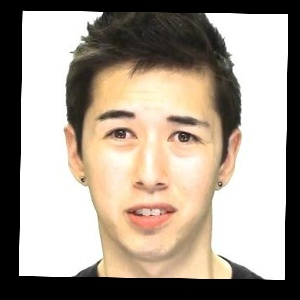
Original:

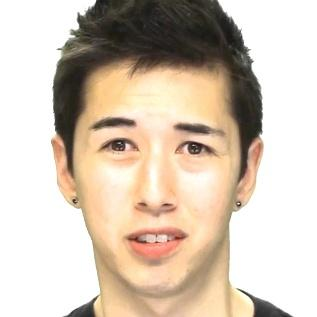

We try to train a model from the new face cropped dataset but the result is worse compared to the original dataset.
We can observe two reason leading the performance downgrade.
The first one is the face crop will actually remove some images from the dataset that is too blurred to be recognized as a face(But these images can still be valuable for training). The second one is the face crop actually zoom in the face and leaving some black borders.

So in the remaing part of the project, we will use the original dataset without face crop.

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from keras.applications import MobileNetV3Large
from keras import layers

# The function to plot the training vs testing history
def plot_history(history):
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="train_acc")
    plt.plot(history.history["val_accuracy"], label="val_acc")
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.title("Loss")
    plt.show()

# if gpu, set memory growth
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(f"GPU is available: {physical_devices[0]}")

GPU is available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [5]:
# Global variables
SEED = 123
IMG_SIZE = 317
BATCH_SIZE = 64

DATASET_PATH = "./project_data_2classes"

tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)

We defined the image augmentation here, with a validation split of 15%, slightly higher than the original splitting.

In [6]:
# load data and image augmentation

train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.1,
    shear_range=0.2,
    validation_split=0.15
)

val_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.15
)

train_ds = train_gen.flow_from_directory(
    directory=DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True,
    seed=SEED,
    subset="training"
)

val_ds = val_gen.flow_from_directory(
    directory=DATASET_PATH,
    target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True,
    seed=SEED,
    subset="validation"
)

Found 46866 images belonging to 2 classes.
Found 8270 images belonging to 2 classes.


# 2. Custom CNN Model
Our first approach is to build our own CNN model to observe the performance.
CNN is generally a good network for image classification shown by a lot of researches. The convolution layers can extract lower features and general feature with more layers, so it is also a good approach for deep fake image classification.

In our model, we define the CNN model with 3 convolution layer, with all 3x3 kernel with same padding, activated by ReLu. We also add a max pooling layer after each convolution layer to reduce the dimension. We also add a global average pooling layer after convolution layers to reduce the dimension,and a dropout layer to reduce overfitting. The output layer is a sigmoid layer to perform binary classification.


In [ ]:
tf.keras.backend.clear_session()

inputs_cnn = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Conv2D(64, kernel_size=(3,3), activation="relu",padding="same")(inputs_cnn)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(64, kernel_size=(3,3), activation="relu",padding="same")(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(32, kernel_size=(3,3), activation="relu",padding="same")(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)

x = layers.GlobalAvgPool2D()(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs_cnn = layers.Dense(1, activation="sigmoid")(x)

model_cnn = keras.Model(inputs_cnn, outputs_cnn)
optimizer_cnn = keras.optimizers.Adam(0.001)
model_cnn.compile(
    optimizer=optimizer_cnn, loss="binary_crossentropy", metrics=["accuracy"]
)

model_cnn.summary()


In [ ]:
# train the cnn
epochs = 10
history_cnn = model_cnn.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    # callbacks=[lr_scheduler],
    workers=14,
)


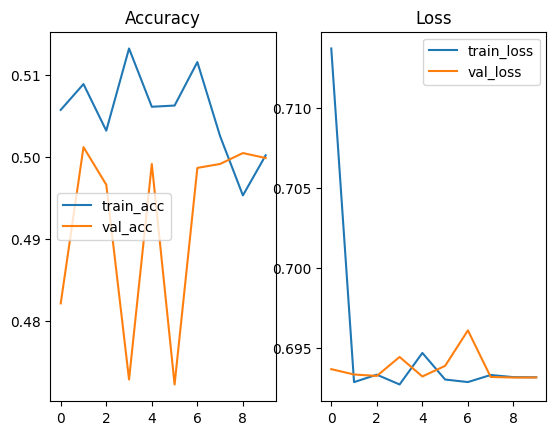

In [16]:
plot_history(history_cnn)
model_cnn.save("very_bad_cnn.h5")

## Result Analysis on Custom CNN
Obviously, the model does not capture the feature of the images well. The unstable train acc and val acc reflect that the model's classification performance is bad. Although the train loss is decreasing by epochs, the validation loss is increasing, which means the model is overfitting. 
In conclusion, the model is not able to generalize well on the validation dataset, and not performing well on the trainset as well.

This imply two possible reason for the result:
1) The first one is that the model acrhitecture is not complex enough to capture the features of the images.
2) The dataset is too small to train a good model.

The 2) issue is a constant in this project since we have a fixed size dataset. So we will mainly focus on the 1) reason in the following part.

# 3. Transfer Learning
Transfer learning is a techique that utiilized a backbone model with a pre-trained weight and using that pre-trained model to perform the new tasks. For the above reason, we will use transfer learning to perform the image classification. It can be a good approach to solve the 1) issue since the pre-trained model is trained on the ImageNet and can is proven to be good at capturing the general features of the images.
 We will use the EfficientNetV2B0 model as our backbone model, which is a lighter-weight model with good performance compare to B7. 
 
Since we are using the pretrained weight, we set the include_top=False to add out own classifiaction layer at the output so that it can learn a binary classification(in construct to imagenet's 1000)
We use global average pooling layer as the original model suggested followed by a small dropout and a linear layer with sigmoid activation to perform binary classification.

In [7]:
from keras.applications import EfficientNetV2B0

tf.keras.backend.clear_session()

inputs_effnet = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
efficientnet = EfficientNetV2B0(include_top=False, weights="imagenet", input_tensor=inputs_effnet)

# Freeze the model weights
efficientnet.trainable = False

# Rebuild top
x = efficientnet(inputs_effnet, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

# Compile
model_effnet = keras.Model(inputs_effnet, outputs)

optimizer_mbnet = keras.optimizers.Adam(0.001)
model_effnet.compile(
    optimizer=optimizer_mbnet, loss="binary_crossentropy", metrics=["accuracy"]
)

model_effnet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 317, 317, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, 10, 10, 1280)     5919312   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 32)                40992     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33    

In [8]:
epochs = 10
history_mbnet = model_effnet.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    # callbacks=[lr_scheduler],
    workers=12,
)


Epoch 1/10
733/733 [==============================] - 137s 177ms/step - loss: 0.6539 - accuracy: 0.6110 - val_loss: 0.7154 - val_accuracy: 0.5185
Epoch 2/10
733/733 [==============================] - 119s 161ms/step - loss: 0.6236 - accuracy: 0.6444 - val_loss: 0.7296 - val_accuracy: 0.5181
Epoch 3/10
733/733 [==============================] - 106s 143ms/step - loss: 0.6077 - accuracy: 0.6640 - val_loss: 0.7404 - val_accuracy: 0.5336
Epoch 4/10
733/733 [==============================] - 113s 153ms/step - loss: 0.5907 - accuracy: 0.6792 - val_loss: 0.7690 - val_accuracy: 0.5328
Epoch 5/10
733/733 [==============================] - 130s 175ms/step - loss: 0.5763 - accuracy: 0.6919 - val_loss: 0.7673 - val_accuracy: 0.5387
Epoch 6/10
733/733 [==============================] - 108s 145ms/step - loss: 0.5647 - accuracy: 0.7003 - val_loss: 0.7806 - val_accuracy: 0.5312
Epoch 7/10
733/733 [==============================] - 108s 146ms/step - loss: 0.5538 - accuracy: 0.7102 - val_loss: 0.7922 -

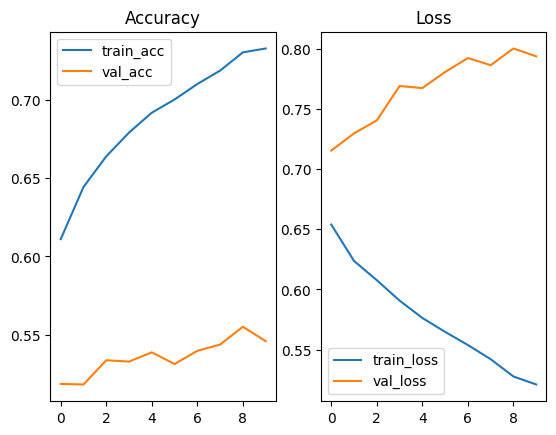

In [9]:
plot_history(history_mbnet)
model_effnet.save("efficientnet_no_finetune.h5")

## Result Analysis on Transfer Learning
First we compare the result to the custom CNN model. 
The performance is better. The train accuracy and validation accuracy are both stable and increasing by epochs. 
However, The train loss and val loss are not decraesing. The model is still overfitting and not performing well on the validation dataset. However, the result is much better than the custom CNN model. The line indicating the acc and loss are much more stable than the custom CNN model. 


The above result is as expected, not good enough because the pre-trained weight are trained on imagenet and not specialised on the deep fake dataset. So we need to fine tune the model to perform better on the deep fake dataset.

# 4. Transfer Learning with Tuning
Reference https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
Reference https://keras.io/guides/transfer_learning/
We first need to select the right layers to unfreeze for fine-tuning. This step is very important as much model architecture including the efficientnet we used are not scale in linearly. We need to fine tune the whole block to get the best performance. Stochastically unfreezing certain layer will greatly harm the classification performance and destroy all the pre-trained model learned. 

The second caution is we should not train the batch normalization layer. Since this layer learn the  mean and variance of the input data, it will destroy the pre-trained model's learned mean and variance and thus destroy the featured learned. We set the trainable=False to prevent the layer from training. We also need to set training = False in the efficientnet layer since it will also update it's parameter during validation.

The third caution is the learning rate of the fine tuning should be very small. It will destroy the pre-trained model's weight if it is too large. We set the learning rate to 0.00001(1e-5)

We print the model's layers to decide which layers fine tune:

In [13]:
for i, layer in enumerate(efficientnet.layers):
    print(i, layer.name)
    # check for not <class 'keras.layers.normalization.batch_normalization.BatchNormalization'>
    if isinstance(layer, layers.BatchNormalization):
        print(f"layer {i} is batchnorm, not trainable")
    # elif "block6" in layer.name or "block5" in layer.name or i > (len(efficientnet.layers) - 10):
    elif "block6" in layer.name or i > (len(efficientnet.layers) - 10):
        print(f"layer {i} is trainable")
    else:
        continue

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
layer 4 is batchnorm, not trainable
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
layer 7 is batchnorm, not trainable
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
layer 10 is batchnorm, not trainable
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
layer 13 is batchnorm, not trainable
14 block2b_expand_conv
15 block2b_expand_bn
layer 15 is batchnorm, not trainable
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
layer 18 is batchnorm, not trainable
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
layer 22 is batchnorm, not trainable
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
layer 25 is batchnorm, not trainable
26 block3b_expand_conv
27 block3b_expand_bn
layer 27 is batchnorm, not trainable
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
layer 30 is 

In [14]:
efficientnet.trainable = True
for i, layer in enumerate(efficientnet.layers):
    # check for not <class 'keras.layers.normalization.batch_normalization.BatchNormalization'>
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    # elif "block6" in layer.name or "block5" in layer.name or i > (len(efficientnet.layers) - 10):
    elif "block6" in layer.name or i > (len(efficientnet.layers) - 10):
        layer.trainable = True
    else:
        layer.trainable = False
        


In [15]:
optimizer_mbnet = keras.optimizers.Adam(0.00001)
model_effnet.compile(
    optimizer=optimizer_mbnet, loss="binary_crossentropy", metrics=["accuracy"]
)


efficientnet.summary(show_trainable=True)
model_effnet.summary()

Model: "efficientnetv2-b0"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_1 (InputLayer)           [(None, 317, 317, 3  0           []                               N          
                                )]                                                                           
                                                                                                             
 rescaling (Rescaling)          (None, 317, 317, 3)  0           ['input_1[0][0]']                N          
                                                                                                             
 normalization (Normalization)  (None, 317, 317, 3)  0           ['rescaling[0][0]']              N          
                                                                                             

In [ ]:
epochs = 20
history_mbnet2 = model_effnet.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    # callbacks=[lr_scheduler],
    workers=12,
)


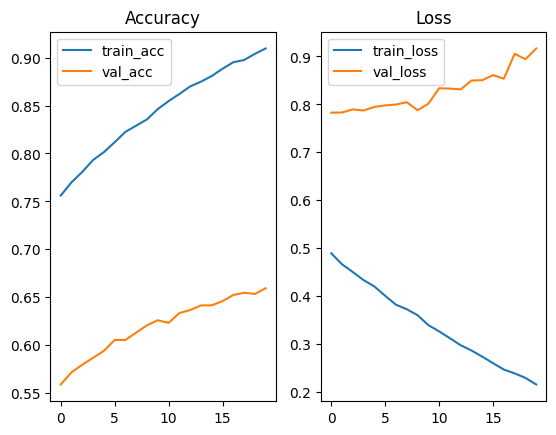

In [17]:
plot_history(history_mbnet2)
model_effnet.save("efficientnet_finetune.h5")

## Result Analysis on Transfer Learning with Tuning
Comparing the result with the transfer learning without tuning, we can see that the performance is improved. The accuracy is greatly improve and has a stable increasing trend. However, the validation loss is still increase. We halt the training due to the increasing sign of the validation loss

Since this time the model can capture the feature well on the training set, we identify the problem is on the over fitting is caused by the small dataset size. The validation loss is increasing after 10 epochs on fine-tuning the last block in efficientnet, this means the model is over fitting the training dataset and not able to generalize well on the validation dataset, which is a bad sign that indicate the model is still over fitting the training dataset.


# 5. Deepfake detection with more augmentation
As we experiment with different model and parameters on the section above, we find out that the model is over fitting on to the training dataset and the accuracy on the validation set improve slowly, while the validation loss keep increasing. We research on the internet and find out some experience and paper for the deep fake detection.

`Cross-Forgery Analysis of Vision Transformers and CNNs for Deepfake Image Detection https://doi.org/10.1145/3512732.3533582`

We first obtain some insight from the paper Cross-Forgery Analysis of Vision Transformers and CNNs for Deepfake Image Detection. The main contribution of this paper is to compare the performance of vision transformer and CNN in deep fake image detection. The author conduct experiments to compare the performance of the above on different deepfake generation methods including Face Transfer, Face Swap, FaceEditing. The author  apply transformations on image during training, including `Isotropic Resizeing, image compression, gaussian noise, horizontal flip, brightness or saturation distortion, grayscale conversion and shift, rotation or scaling`.  The result of this paper shows that the classification performance of CNN is better than Vision Transformer in deepfake detection, while Vision Transformers perform better at generalization,CNN perform better at accuracy.

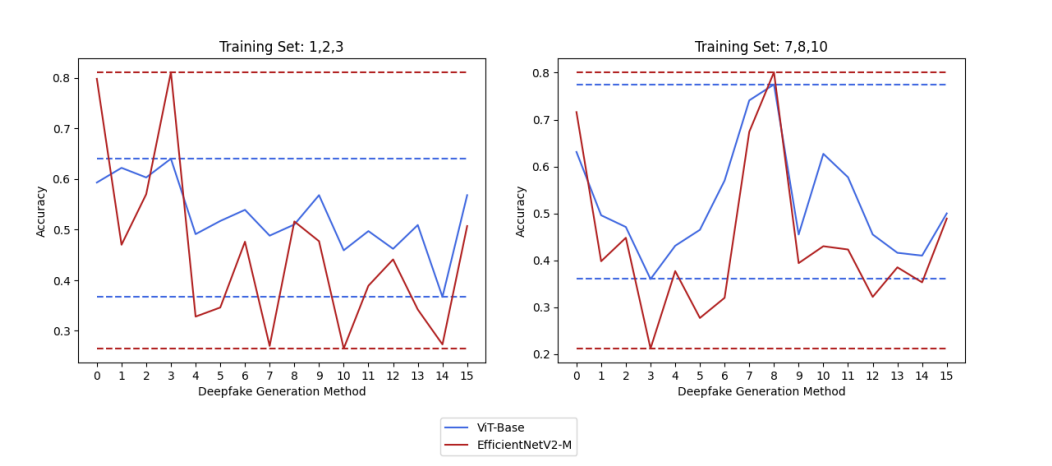


Another resource we obtained are:
The github repository:`https://github.com/selimsef/dfdc_deepfake_challenge` from selimsef. Which is the winner of a deep fake detection challenge on kaggle.

Further reading, we found out that in this approach, a simple model using cnn and efficientnet as backbone is feasible for deep fake classification tasks, as stated in the repo, simple is the best. The image augmentation methods used are much more compare to our own mode. The project state that the data preprocessing is the key to improve the accuracy and lower the loss of the model.


The result of the resources above stating that our direction on applying transfer leanring to classify deep fake image is correct, and we need to apply more image preprocessing technique to obtain a better performance on the model.

We try to implement and apply the image augmentation method as state from the above resources to see if we can re-create the good accuracy, but keras and tensorflow's built in method for image augmentation is limited so we switch to pytorch workflow and utilized the image augmentation libaray `albumentation` for image augmentation.

In [1]:
# Restart the python kernel to free up memory and avoid conflict

import torch
import random
import os
import cv2
import numpy as np

from sklearn.model_selection import train_test_split

import timm

from albumentations import Compose, RandomBrightnessContrast, \
    HorizontalFlip, FancyPCA, HueSaturationValue, OneOf, ToGray, \
    ShiftScaleRotate, ImageCompression, PadIfNeeded, GaussNoise, DualTransform

from tqdm import tqdm

from torch.utils.tensorboard import SummaryWriter

# Set the image size to 224
IMAGE_SIZE = 224
random.seed(42)

C:\Users\Doge\anaconda3\envs\mlpy310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [293]:
# set the device to cuda if available to speed up training
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Load data

# Since the dataset is about 500Mb, we decide to put the whole dataset into memory
 # input data floder path
folder_path = './project_data_2classes'

dataset = []
labels = []

# iterate through all the file structures and load all the JPG or PNG files
for root, folders, files in os.walk(folder_path):
    for file in files:
        if not file.endswith('.jpg') | file.endswith('.png'):
            continue
        
        # only load the address to the images but not the images thamselves to save time
        dataset.append(f'{root}/{file}')
        labels.append(0 if ('Fake' in root) | ('fake' in root) else 1)

# Train test split
# We use 90% of the data for training and 10% for validation here

train_dataset, validation_dataset, train_labels, validation_labels = train_test_split(dataset, labels, test_size=0.1, random_state=42)
del dataset

## 5.1 Image preprocessing
According to the resource above and various deep fake detection implementation and online resources, we found out that the image preprocessing is the key to improve the generalization ability and accuracy of the model. It is even more important than the model architecture selection. Without using a large parameter model like vision transformer, we can still achieve a good accuracy with a simple model by using proper image preprocessing for face.


We apply the same image augmentation method as the above resources, including:
`Isotropic Resizeing, image compression, gaussian noise, horizontal flip, random brightness,random saturation,random distortion, grayscale and shift, rotation or scaling`


In [4]:
# https://github.com/selimsef/dfdc_deepfake_challenge/tree/master
# There is minimal information about isotropic resizeing, so we adapt the code from the above repo
# It resize the images and make sure the height and width are the same across all input images

class IsotropicResize(DualTransform):
    def __init__(self, max_side, interpolation_down, interpolation_up):
        super(IsotropicResize, self).__init__(False, 1)
        self.max_side = max_side
        self.interpolation_down = interpolation_down
        self.interpolation_up = interpolation_up

    def apply(self, img, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC, **params):

        h, w = img.shape[:2]

        if max(w, h) == self.max_side:
            return img
        if w > h:
            scale = self.max_side / w
            h = h * scale
            w = self.max_side
        else:
            scale = self.max_side / h
            w = w * scale
            h = self.max_side
        interpolation = interpolation_up if scale > 1 else interpolation_down

        img = img.astype('uint8')
        resized = cv2.resize(img, (int(w), int(h)), interpolation=interpolation)
        return resized

    def apply_to_mask(self, img, **params):
        return self.apply(img, interpolation_down=cv2.INTER_NEAREST, interpolation_up=cv2.INTER_NEAREST, **params)

    def get_transform_init_args_names(self):
        return ("max_side", "interpolation_down", "interpolation_up")

The image augmentation is defined in the dataloader, as we stated, we are composing the albumentation workflow to perform the image augmentation. 
The augmentation is performed on the training dataset only.

In [5]:
# Define dataloader
class DeepFakesDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, image_size, mode='train'):
        self.image_paths = image_paths
        self.labels = torch.from_numpy(labels)
        self.image_size = image_size
        self.mode = mode
        self.n_samples = len(image_paths)
    
    # for the training set, we create more variation of the images so that our model can deal with different situations.
    def create_train_transforms(self, size):
        return Compose([
            ImageCompression(quality_lower=60, quality_upper=100, p=0.2),
            GaussNoise(p=0.3),
            HorizontalFlip(),
            OneOf([
                IsotropicResize(max_side=size, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC),
                IsotropicResize(max_side=size, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_LINEAR),
                IsotropicResize(max_side=size, interpolation_down=cv2.INTER_LINEAR, interpolation_up=cv2.INTER_LINEAR),
            ], p=1),
            PadIfNeeded(min_height=size, min_width=size, border_mode=cv2.BORDER_CONSTANT),
            OneOf([RandomBrightnessContrast(), FancyPCA(), HueSaturationValue()], p=0.4),
            ToGray(p=0.2),
            ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=5, border_mode=cv2.BORDER_CONSTANT, p=0.5),
        ]
        )
        
    # only resize and pad the borders if needed for the validation set.
    def create_val_transform(self, size):
        return Compose([
            IsotropicResize(max_side=size, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC),
            PadIfNeeded(min_height=size, min_width=size, border_mode=cv2.BORDER_CONSTANT),
        ])

    # only load the images when needed and transform based on the mode (training or validation/testing)
    def __getitem__(self, index):
        image = np.asarray(cv2.imread(self.image_paths[index]))
        
        if self.mode == 'train':
            transform = self.create_train_transforms(self.image_size)
        else:
            transform = self.create_val_transform(self.image_size)
        
        image = transform(image=image)['image']
        
        return torch.tensor(image).float(), self.labels[index]

    def __len__(self):
        return self.n_samples

In [ ]:
# Create the data loaders
# Adjust the batch size according to the GPU memory
BATCH_SIZE = 64 # lower for smaller GPU memory

train_dataset = DeepFakesDataset(train_dataset, np.asarray(train_labels), IMAGE_SIZE)
dl = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
del train_dataset

validation_dataset = DeepFakesDataset(validation_dataset, np.asarray(validation_labels), IMAGE_SIZE, mode='validation')
val_dl = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
del validation_dataset

In [ ]:
# The evaluate function to calculate the correct predictions, positive class and negative class
def evaluate(preds, labels):
    rounded_preds = preds.round()

    correct = sum(pred == label for pred, label in zip(rounded_preds, labels)).item()
    positive_class = int(sum(rounded_preds).item())
    negative_class = (len(rounded_preds) - positive_class)
    
    return correct, positive_class, negative_class

# 5.2 Pretrained model
EfficientNet shows the capability on deep fake image classification tasks,
so we are using it with pretrained weight on imagenet and fine-tune the model.
This time, we switch to efficentnetv2 m, which is a more powerful pretrained model compare to the previous one.

In [ ]:
# Load efficientnetv2_m model with pre-trained weights
# num_classes=1 for binary classification
model = timm.create_model('tf_efficientnetv2_m', pretrained=True, num_classes=1)

# Same as above, we freeze all layers except the last 10 layers and blocks.5 and blocks.6
for index, (name, param) in enumerate(model.named_parameters()):
    if "blocks.6" in name or "blocks.5" in name or index > len(list(model.parameters()))-10:
        param.requires_grad = True
    else:                    
        param.requires_grad = False

# 5.3 Model Training
We train the model for the classification tasks.
Compared to tensorflow keras's`model.fit()`, more boilerplate code is written in pytorch, but it also provide more flexibility to control the train and test cycle. 

In [ ]:
# Training

# hyperparameters
PATIENCE = 3
MAX_EPOCHS = 30
LEARNING_RATE = 0.01
WEIGHT_DECAY = 0.0000001
STEP_SIZE = 15
GAMMA = 0.1

# paths for saving the model and logger
MODEL_PATH = 'torch_models' # Name the folder for the models
LOGGER_PATH = 'runs/train' # Name the folder for the logger

tb_logger = SummaryWriter(log_dir=LOGGER_PATH, comment='')
experiment_path = tb_logger.get_logdir()

# Calculating class weights for the loss function
class_weights = sum(labels) / (len(labels) - sum(labels))
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([class_weights]))

# Defining the optimizer and learning rate scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

# Model: Transfer to GPU for faster training or CPU, defined above
model = model.to(device)

# Early stopping counter
early_stop_count = 0
best_loss = float('inf')

# Training loop
for epoch in range(MAX_EPOCHS):
    
    # If the validation loss has not improved for a number of epochs stop training
    if early_stop_count == PATIENCE:
        break

    # Train loop: variables to hole the loss and accuracy for each epoch
    total_train_loss = 0
    train_correct = 0
    train_positive = 0
    train_negative = 0
    train_counter = 0

    # Train loop: loop over the training dataloader batche
    model.train()

    pbar = tqdm(dl, total=len(dl))
    for images, labels in pbar:
        # unsqueeze to match the dimension
        labels = labels.unsqueeze(1)
        # transpose the images to match the input dimension of the model and move them to the GPU if available
        images = np.transpose(images, (0, 3, 1, 2))
        images = images.to(device)
        # Forward pass
        y_pred = model(images)
        y_pred = y_pred.cpu()
        
        # calculate the loss by loss func
        loss = loss_fn(y_pred, labels.float())
        
        # Evaluate the predictions on train data
        correct, positive_class, negative_class = evaluate(torch.sigmoid(y_pred.detach()), labels)
        train_correct += correct
        train_positive += positive_class
        train_negative += negative_class
        train_counter += 1
        
        # Backward pass
        optimizer.zero_grad() # remember to zero_grad
        loss.backward()
        optimizer.step()
        
        # Accumulate the total loss as defined per epoch
        total_train_loss += round(loss.item(), 2)
        
        # Show the loss and accuracy for tracking
        pbar.set_description(f'Training epoch: {epoch}/{MAX_EPOCHS}, loss: {total_train_loss/train_counter:.4f}, acc: {train_correct/(train_counter*BATCH_SIZE):.4f}, 0s/1s: {train_negative}/{train_positive}')


    # Compute the average loss and accuracy over the epoch
    train_correct /= dl.dataset.n_samples
    total_train_loss /= train_counter
    
    # Test loop: variables to hole the loss and accuracy for each epoch
    total_val_loss = 0
    val_correct = 0
    val_positive = 0
    val_negative = 0
    val_counter = 0

    # Validation loop:loop validation dataloader batches
    model.eval()

    pbar = tqdm(val_dl, total=len(val_dl))
    for val_images, val_labels in pbar:
        
        # same as above to match dimension and move to GPU
        val_labels = val_labels.unsqueeze(1)
        val_images = np.transpose(val_images, (0, 3, 1, 2))
        val_images = val_images.to(device)
        
        # Forward pass
        with torch.no_grad():
            val_pred = model(val_images)
            val_pred = val_pred.cpu()
            # validation loss
            val_loss = loss_fn(val_pred, val_labels.float())
            # Evaluate the predictions on test data(validation data)
            corrects, positive_class, negative_class = evaluate(torch.sigmoid(val_pred), val_labels)

        val_correct += corrects
        val_positive += positive_class
        val_negative += negative_class
        val_counter += 1
        
        # NO backprop for validation
        
        # same as above,gather the total loss per epoch
        total_val_loss += round(val_loss.item(), 2)

        # Show the loss and accuracy for tracking
        pbar.set_description(f'Validate epoch: {epoch}/{MAX_EPOCHS}, loss: {total_val_loss/val_counter:.4f}, acc: {val_correct/(val_counter*BATCH_SIZE):.4f}, 0s/1s: {val_negative}/{val_positive}')
    
    # Update the learning rate by the LR scheduler
    scheduler.step()
    
    # Compute the average validation loss and accuracy over the epoch
    val_correct /= val_dl.dataset.n_samples
    total_val_loss /= val_counter
    
    # If validation loss is not improving,increase the early stop counter.
    if best_loss <= total_val_loss:
        tqdm.write('Validation loss did not improved')
        early_stop_count += 1
    else:
        best_loss = total_val_loss
        early_stop_count = 0
    
    # tensorboard logging
    tb_logger.add_scalar('Training/Accuracy', train_correct, epoch)
    tb_logger.add_scalar('Training/Loss', total_train_loss, epoch)
    tb_logger.add_scalar('Training/Learning_Rate', optimizer.param_groups[0]['lr'], epoch)
    tb_logger.add_scalar('Validation/Loss', total_val_loss, epoch)
    tb_logger.add_scalar('Validation/Accuracy', val_correct, epoch)
    
    # error handling if path not exists
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)
    
    # save the model of this epoch
    torch.save(model.state_dict(), os.path.join(MODEL_PATH, f'model_{epoch}'))

## Result Analysis on Transfer Learning with Tuning with more augmentation

Training Accuracy

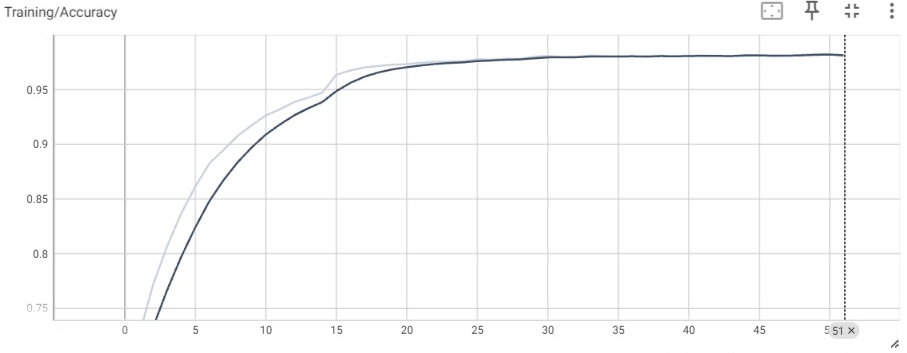

Validation Accuracy

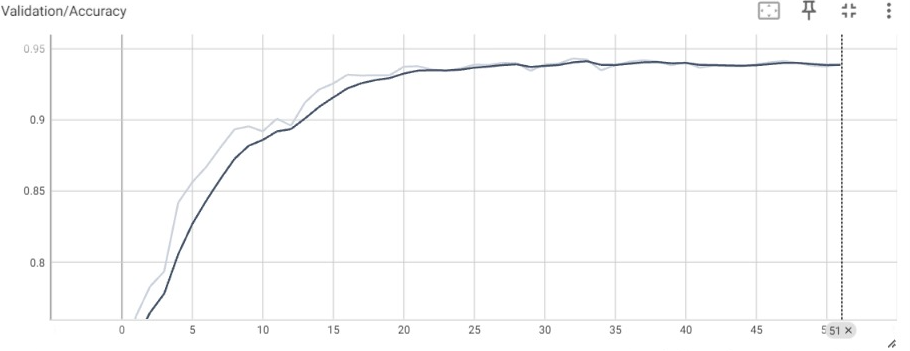


This above plots was generated by the torch.utils.tensorboard.SummaryWriter. Since we recorded the training log, VScode users can directly use the TensorBoard extension to view the plot of the training process.

By far, this approach genrated the best result, as the epoch goes, the both train and validation accuracy increase, and the loss goes down. We train the model for 50 epochs and the model is able to converge. Which is a very good sign to show that the model can finally learn the right feature of the images and generalize well on the validation dataset. 
We get above 95% train acc and over 90% validation acc, and both loss lower than 10%.

Compare to the previous transfer learning model, all we do is to increase and apply more advanceed image augmentation technique, with a similar model architecture (efficientnetv2 m vs efficientnetv2 b0), both trained on imagenet. The result shows that the image preprocessing is the key to improve the model performance.

# 5.4 Model Testing
We test the model for the classification tasks.
The testing procedure is similar to training. We load the data, and predict it with the trained model.

In [ ]:
# Load data
test_folder_path = 'project_data' # input test data floder

test_dataset = []
test_labels = []

for root, folders, files in os.walk(test_folder_path):
    for file in files:
        if not file.endswith('.jpg') | file.endswith('.png'):
            continue
        
        dataset.append(f'{root}/{file}')
        labels.append(0 if ('Fake' in root) | ('fake' in root) else 1)

In [ ]:
# Create the data loaders
BATCH_SIZE = 64

test_dataset = DeepFakesDataset(test_dataset, np.asarray(test_labels), IMAGE_SIZE, mode='validation')
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# Testing

# select a model saved in the training
MODEL_PATH = "./model_33_10"

model = timm.create_model('tf_efficientnetv2_m', pretrained=True, num_classes=1)

# load the trained model
if torch.cuda.is_available():
    model.load_state_dict(torch.load(MODEL_PATH))
else:
    model.load_state_dict(torch.load(MODEL_PATH), map_location=torch.device('cpu'))

model = model.to(device)
faces_preds = torch.Tensor()
all_labels = torch.Tensor()

# Testing loop: loop testing dataloader batches
model.eval()
for images, labels in tqdm(test_dl, desc='Testing'):
    # same as above to match dimension and move to GPU
    images = np.transpose(images, (0, 3, 1, 2))
    images = images.to(device)

    # Forward pass
    with torch.no_grad():
        # predict this batch of images
        y_pred = model(images)
    
    y_pred = y_pred.cpu()

    # store the predictions and the labels
    faces_preds = torch.cat((faces_preds, torch.sigmoid(y_pred)))
    all_labels = torch.cat((all_labels, labels))

# calculate the accuracy, positive cases and negative cases
corrects, positive, negative = evaluate(faces_preds, all_labels)
accuracy = corrects / len(all_labels)
accuracy

# 6. Visualization the classification results
In the last part, we visualize the classification result of the model to verify if the model can actually learn the feature form the images. We use the python library `torchcam` to visualize the result.

Credit to :`https://github.com/frgfm/torch-cam`


In [284]:
# Load the trained model and print the layer name and index
# to locate the layer we want to visualize
MODEL_PATH = "./model_33_10"
model = timm.create_model('tf_efficientnetv2_m', num_classes=1)
model.load_state_dict(torch.load(MODEL_PATH))
model.to("cpu")

for index, (name, param) in enumerate(model.named_modules()):
    param.requires_grad = True


model.eval()
layers = []
# print layer name and index
dict(model.named_modules())

# we locate the name of the layer we want to visualize, bn2 and classifier

{'': EfficientNet(
   (conv_stem): Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
   (bn1): BatchNormAct2d(
     24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
     (drop): Identity()
     (act): SiLU(inplace=True)
   )
   (blocks): Sequential(
     (0): Sequential(
       (0): ConvBnAct(
         (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn1): BatchNormAct2d(
           24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
           (drop): Identity()
           (act): SiLU(inplace=True)
         )
         (drop_path): Identity()
       )
       (1): ConvBnAct(
         (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn1): BatchNormAct2d(
           24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
           (drop): Identity()
           (act): SiLU(inplace=True)
         )
         (drop_path): Identity()
       )

In [289]:

from torchcam.methods import CAM
cam_extractor = CAM(model,target_layer="bn2",fc_layer="classifier")

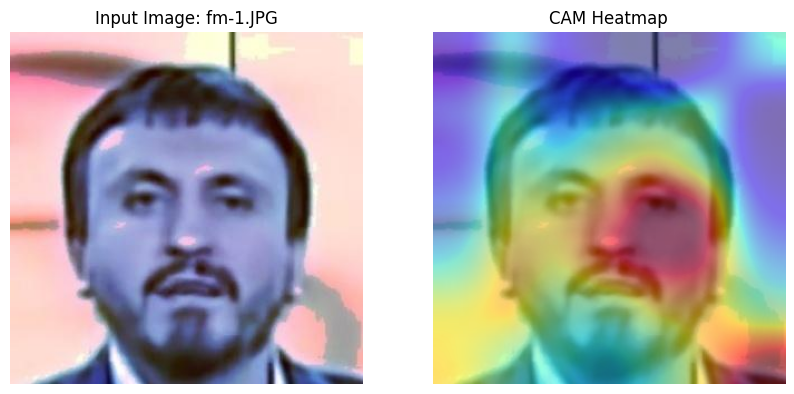

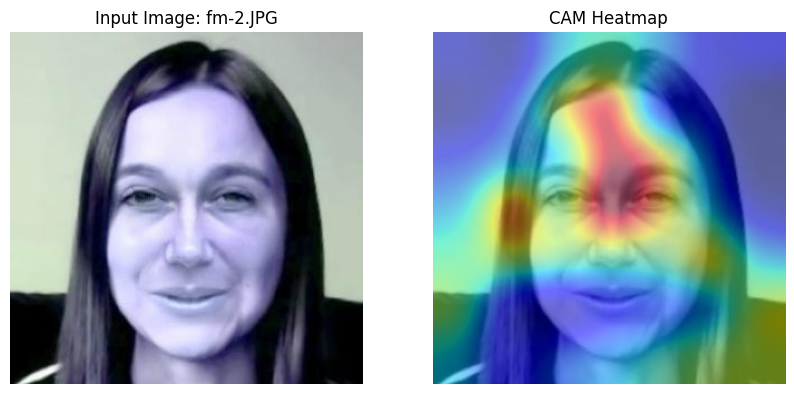

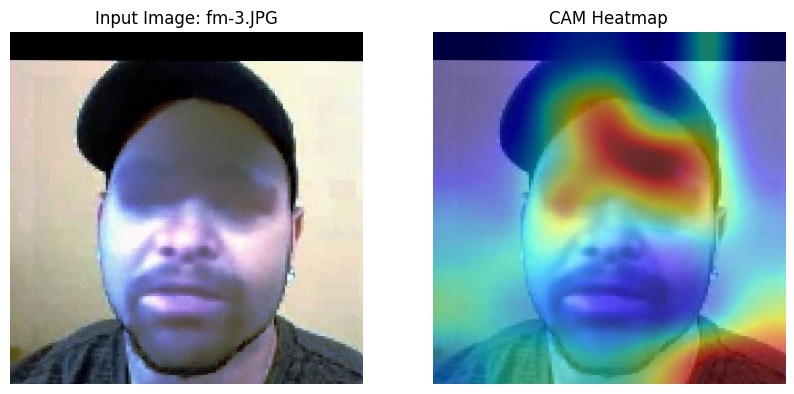

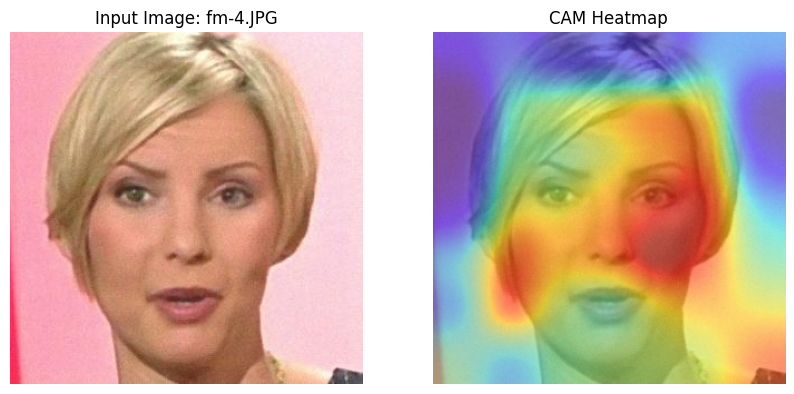

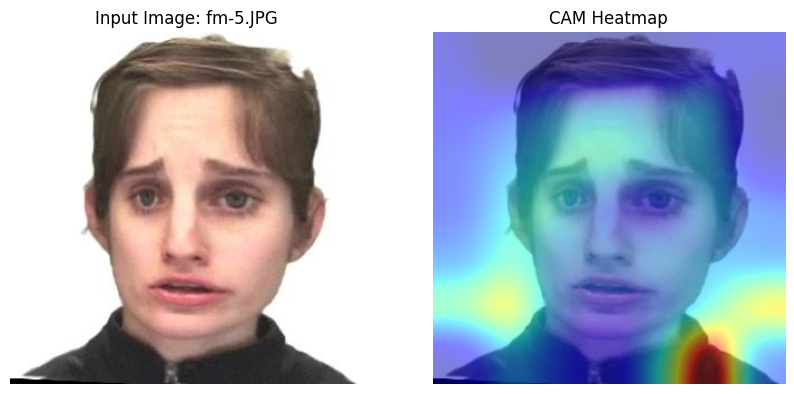

In [291]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask


img_array = ["./ipynb_images/fm-1.JPG", 
             "./ipynb_images/fm-2.JPG",
             "./ipynb_images/fm-3.JPG",
             "./ipynb_images/fm-4.JPG",
             "./ipynb_images/fm-5.JPG",]

for img_i in img_array:
    img = read_image(img_i)
    input_tensor = normalize(resize(img, (224, 224),antialias=True) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    

    out = model(input_tensor.unsqueeze(0))
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

    result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
    
    # Display
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')
    plt.title(f'Input Image: {img_i[-8:]}')
    # heatmap on second row
    plt.subplot(1, 2, 2)
    plt.imshow(result)
    plt.axis('off')
    plt.title('CAM Heatmap')
    plt.savefig(f'./ipynb_images/{img_i[-8:-4]}_cam.jpg')
    plt.show()


(If it is unable to show the above image, you can locate in on ./ipynb_images/fm_1_cam.jpg

The five samples are from fake manipulation 1(fm-1) to 5(fm-5) respectively, 
The result shows that the model can learn the feature of the images. Area that is highlighted with red means activation in model layers.
Although the model also treat some background as feature, the majority of the highlighted area are the face of the person in the image. We can see that in FM-1 and FM-2 where the semantic attribute are identity, the model will hightlight a majority part in on the face.
In FM-3 and FM-4 where the semantic attribute are expression and identity, it highlight the eyes on the face which can express the expression of the person. We can see that the deep fake is likely to be transforming the eyes' area.

In FM-5, the main semantic is head pose. In the sample, the CAM can also highlight the fore head of the face. However, the model will also treat the cloth as a feature which is an wrong feature.

Overall, the model can be able to learn the feature of the face and perform well on the deepfake classification task.

# 7. Project Conclusion
In this project, we try and validate different model architecture, from a simple custom CNN model, then a transfer learning on efficietnet, and finally a transfer learning with tuning and advanced image augmentation. We apply different image preprocessing technique to improve the model performance.

In conclusion, we obtain the best result with efficientnet as backbone. The experiment shows that the key to make a good image classifier may not always depend on a very complex model architecture, but the image preprocessing. 
The image preprocessing is crucial to make the generalization well on the validation dataset compareing the result of the same network but with few less image augmentation technique.
 
Finally, we visualize the classification result of the model to verify if the model can actually learn form the correct feature in the face.The CAM images show that the model can learn the feature of the correct deep fake transformation on the face, and have very good classification ability in general.

# This is the end of the project. Thank you for reading!